# Exploring CAFE-f6 bias correction

This notebook demonstrates forecast drift in a few models and explores various simple approaches to bias correction for CAFE-f6

In [1]:
import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
%load_ext lab_black

In [3]:
xr.set_options(keep_attrs=True)

### Open some prepared data
Focussing on global mean quanities in this notebook

In [4]:
def global_mean(ds):
    return ds.weighted(ds["area"]).mean(["lat", "lon"])

In [5]:
DATA_DIR = "../../data/processed/"

In [6]:
variables = ["t_ref", "precip", "sst", "ohc300"]

f6_hcst = xr.merge(
    [xr.open_zarr(f"{DATA_DIR}/CAFEf6.{v}.zarr") for v in variables],
)
f6_hcst = global_mean(f6_hcst.mean("member")).compute()

In [7]:
variables = ["t_ref", "precip", "sst", "ohc300"]

f5_hcst = xr.merge(
    [xr.open_zarr(f"{DATA_DIR}/CAFEf5.{v}.zarr") for v in variables],
)
f5_hcst = global_mean(f5_hcst.mean("member")).compute()

In [8]:
variables = ["t_ref", "precip", "sst", "ohc300"]

cafe_60 = xr.merge(
    [xr.open_zarr(f"{DATA_DIR}/CAFE60v1.{v}.zarr") for v in variables],
)
cafe_60 = global_mean(cafe_60.mean("member")).compute()

In [9]:
variables = ["t_ref", "precip", "sst", "ohc300"]

cafe_hist = xr.merge(
    [xr.open_zarr(f"{DATA_DIR}/CAFE_hist.{v}.zarr") for v in variables],
)
cafe_hist = global_mean(cafe_hist.mean("member")).compute()

In [10]:
variables = ["t_ref", "precip", "sst"]

CanESM5_hcst = xr.merge(
    [xr.open_zarr(f"{DATA_DIR}/CanESM5.{v}.zarr") for v in variables],
)
CanESM5_hcst = global_mean(CanESM5_hcst.mean("member")).compute()

In [11]:
variables = ["t_ref", "precip", "sst"]

CanESM5_hist = xr.merge(
    [xr.open_zarr(f"{DATA_DIR}/CanESM5_hist.{v}.zarr") for v in variables],
)
CanESM5_hist = global_mean(CanESM5_hist.mean("member")).compute()

In [12]:
variables = ["t_ref", "precip", "sst"]

EC_Earth3_hcst = xr.merge(
    [xr.open_zarr(f"{DATA_DIR}/EC_Earth3.{v}.zarr") for v in variables],
)
EC_Earth3_hcst = global_mean(EC_Earth3_hcst.mean("member")).compute()

In [13]:
variables = ["t_ref", "precip", "sst"]

EC_Earth3_hist = xr.merge(
    [xr.open_zarr(f"{DATA_DIR}/EC_Earth3_hist.{v}.zarr") for v in variables],
)
EC_Earth3_hist = global_mean(EC_Earth3_hist.mean("member")).compute()

In [14]:
obs = xr.merge(
    (
        xr.open_zarr(f"{DATA_DIR}/JRA55.t_ref.zarr"),
        xr.open_zarr(f"{DATA_DIR}/GPCP.precip.zarr"),
        xr.open_zarr(f"{DATA_DIR}/HadISST.sst.zarr"),
        xr.open_zarr(f"{DATA_DIR}/EN422.ohc300.zarr"),
    )
)

obs = global_mean(obs).compute()

### Remove the biases

First, let's just calculate the biases from the model climatology over the max consistent period

#### What does CAFE-f6 look like?

In [15]:
def bias_mean(hcst, obs):
    hcst_clim = hcst.mean("init")
    obs_clim = obs.mean("time")
    return hcst_clim - obs_clim

In [16]:
period = [cftime.DatetimeJulian(1990, 1, 1), cftime.DatetimeJulian(2021, 1, 1)]

hcst_period = (f6_hcst.time >= period[0]) & (f6_hcst.time <= period[1])
obs_period = np.unique(f6_hcst.time.values[hcst_period.values])

bias = bias_mean(
    f6_hcst.where(hcst_period),
    obs.sel(time=obs_period),
)


f6_hcst_bc = f6_hcst - bias

In [17]:
def plot_hindcasts(hcsts, hcsts_bc, hist):
    """Plot raw and bias corrected hindcasts"""
    from matplotlib.pyplot import cm
    from matplotlib.dates import date2num

    def shading(ax):
        trans = cftime.DatetimeJulian(1992, 1, 1)
        end = cftime.DatetimeJulian(2040, 1, 1)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(
            [trans, end],
            [ylim[1], ylim[1]],
            [ylim[0], ylim[0]],
            color=[0.9, 0.9, 0.9],
        )
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    n_vars = len(hcsts.data_vars)

    fig = plt.figure(figsize=(10, n_vars * 4))
    axs = fig.subplots(n_vars, 1, sharex=True)
    if n_vars == 1:
        axs = [axs]

    for a, var in enumerate(hcsts.data_vars):
        color = cm.autumn(np.linspace(0, 0.9, len(hcsts[var].init)))
        color_bc = cm.winter(np.linspace(0, 0.9, len(hcsts[var].init)))
        for idx, (i, c) in enumerate(zip(hcsts[var].init, color)):
            if idx == 0:
                label = "Hindcasts raw"
            else:
                label = "_nolabel_"

            hcst = hcsts[var].sel(init=i)
            axs[a].plot(hcst.time[0], hcst[0], color=c, marker="o", label="_nolabel_")
            axs[a].plot(hcst.time, hcst, color=c, linestyle="-", label=label)

        for idx, (i, c) in enumerate(zip(hcsts_bc[var].init, color_bc)):
            if idx == 0:
                label = "Hindcasts bias corrected"
            else:
                label = "_nolabel_"
            hcst = hcsts_bc[var].sel(init=i)
            axs[a].plot(hcst.time[0], hcst[0], color=c, marker="o", label="_nolabel_")
            axs[a].plot(hcst.time, hcst, color=c, linestyle="-", label=label)

        axs[a].plot(obs.time, obs[var], color="black", label="Observations")
        axs[a].plot(
            cafe_60.time, cafe_60[var], color="black", linestyle="--", label="CAFE60v1"
        )
        axs[a].plot(hist.time, hist[var], color="grey", label="Historical run")

        ticks = xr.cftime_range(
            start="1981-01-01", end="2032-01-01", freq="2AS", calendar="julian"
        )
        axs[a].set_xticks(ticks.values)
        axs[a].set_xticklabels(ticks.year)
        axs[a].set_xlim(
            cftime.DatetimeJulian(1981, 1, 1), cftime.DatetimeJulian(2032, 1, 1)
        )
        axs[a].set_ylabel(hcsts[var].attrs["long_name"])
        axs[a].grid()
        if a == 0:
            axs[a].legend()
        if a == (n_vars - 1):
            axs[a].set_xlabel("year")
        else:
            axs[a].set_xlabel("")

        shading(axs[a])

    plt.tight_layout()

    return fig

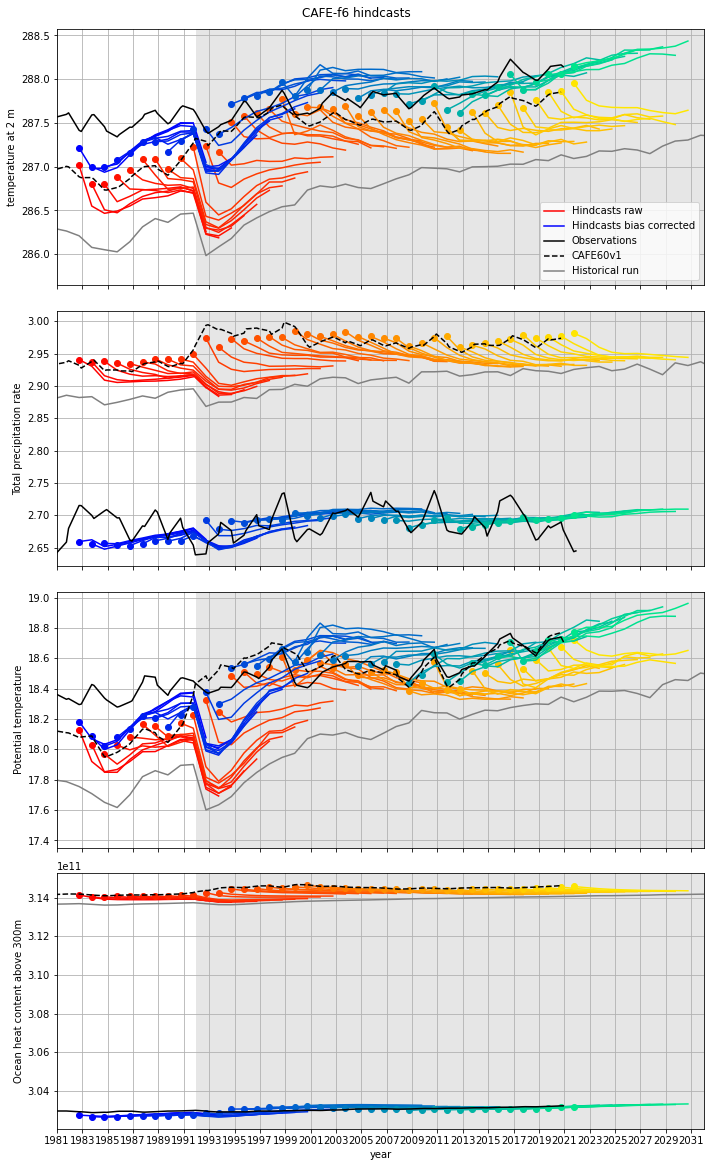

In [18]:
fig = plot_hindcasts(f6_hcst, f6_hcst_bc, cafe_hist)
fig.suptitle("CAFE-f6 hindcasts", fontsize=12, y=1.01)
fig.patch.set_facecolor("w")

#### What does CanESM5 look like?

In [19]:
period = [cftime.DatetimeJulian(1990, 1, 1), cftime.DatetimeJulian(2018, 1, 1)]

hcst_period = (CanESM5_hcst.time >= period[0]) & (CanESM5_hcst.time <= period[1])
obs_period = np.unique(CanESM5_hcst.time.values[hcst_period.values])

bias = bias_mean(
    CanESM5_hcst.where(hcst_period),
    obs.sel(time=obs_period),
)

CanESM5_hcst_bc = CanESM5_hcst - bias

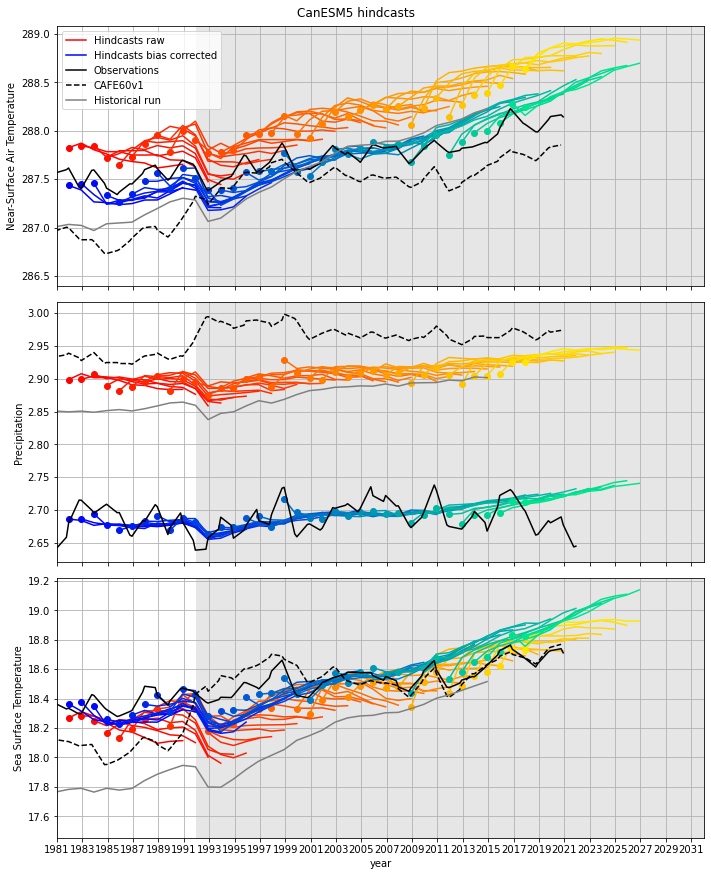

In [20]:
fig = plot_hindcasts(CanESM5_hcst, CanESM5_hcst_bc, CanESM5_hist)
fig.suptitle("CanESM5 hindcasts", fontsize=12, y=1.01)
fig.patch.set_facecolor("w")

#### What does EC-Earth3 look like?

In [21]:
period = [cftime.DatetimeJulian(1990, 1, 1), cftime.DatetimeJulian(2018, 1, 1)]

hcst_period = (EC_Earth3_hcst.time >= period[0]) & (EC_Earth3_hcst.time <= period[1])
obs_period = np.unique(EC_Earth3_hcst.time.values[hcst_period.values])

bias = bias_mean(
    EC_Earth3_hcst.where(hcst_period),
    obs.sel(time=obs_period),
)

EC_Earth3_hcst_bc = EC_Earth3_hcst - bias

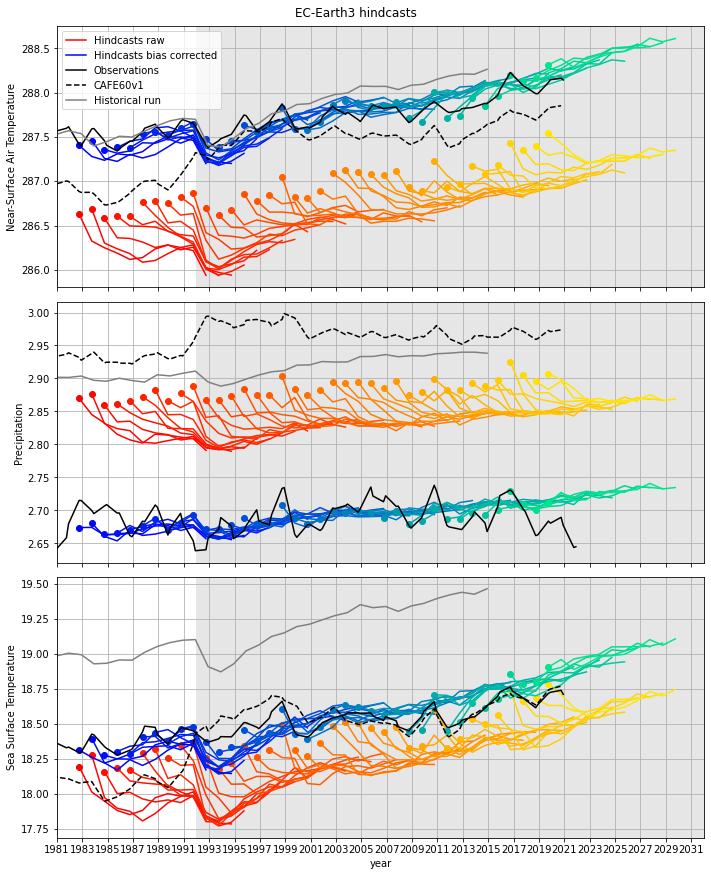

In [22]:
fig = plot_hindcasts(EC_Earth3_hcst, EC_Earth3_hcst_bc, EC_Earth3_hist)
fig.suptitle("EC-Earth3 hindcasts", fontsize=12, y=1.01)
fig.patch.set_facecolor("w")

#### CAFE-f6 obviously has quite a large step around 1992

This is due to the change to CAFE60's bias-correction scheme.

What about if we calculate anomalies for pre and post 1992 separately? Let's use CAFE-f5 so that we can use the same length period for bias correction pre and post the change. **Note that the GPCP dataset used here to provide precipitation observations only goes back to 1979.**

In [23]:
transition_year = 1992

period_1 = [
    cftime.DatetimeJulian(1973, 10, 1),
    cftime.DatetimeJulian(1992, 10, 1),
]  # 20 years, using initial dates < 1992

hcst_period_1 = (f5_hcst.time >= period_1[0]) & (f5_hcst.time <= period_1[1])
obs_period_1 = np.unique(f5_hcst.time.values[hcst_period_1.values])

period_2 = [
    cftime.DatetimeJulian(2002, 10, 1),
    cftime.DatetimeJulian(2021, 10, 1),
]  # 20 years, using initial dates >= 1992

hcst_period_2 = (f5_hcst.time >= period_2[0]) & (f5_hcst.time <= period_2[1])
obs_period_2 = np.unique(f5_hcst.time.values[hcst_period_2.values])

bias_1 = bias_mean(
    f5_hcst.where(hcst_period_1),
    obs.sel(time=obs_period_1),
)

bias_2 = bias_mean(
    f5_hcst.where(hcst_period_2),
    obs.sel(time=obs_period_2),
)

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")

Plot the two period we're using here

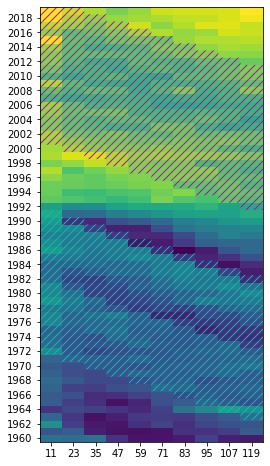

In [24]:
fig, ax = plt.subplots(figsize=(4, 8))

x = np.arange(len(f5_hcst.lead) + 1)
y = np.arange(1, len(f5_hcst.init) + 2) - 0.5
c = f5_hcst["sst"].transpose("init", "lead")
im = ax.pcolor(x, y, c)

ax.set_xticks(np.arange(len(f5_hcst.lead)) + 0.5)
ax.set_xticklabels(f5_hcst.lead.values)
ax.set_yticks(np.arange(1, len(f5_hcst.init) + 1, 2))
ax.set_yticklabels(f5_hcst.init.dt.year.values[::2])


def hatch(mask, color):
    import matplotlib.patches as mpatches

    for j, i in np.column_stack(np.where(mask)):
        ax.add_patch(
            mpatches.Rectangle(
                (i, j + 0.5),
                1,
                1,
                fill=False,
                linewidth=0,
                snap=False,
                color=color,
                hatch="///",
            )
        )


mask = xr.ones_like(f5_hcst["t_ref"]).where(
    (f5_hcst.time >= period_1[0]) & (f5_hcst.time <= period_1[1]),
    0,
)
hatch(mask, "c")
mask = xr.ones_like(f5_hcst["t_ref"]).where(
    (f5_hcst.time >= period_2[0]) & (f5_hcst.time <= period_2[1]),
    0,
)
hatch(mask, "m")

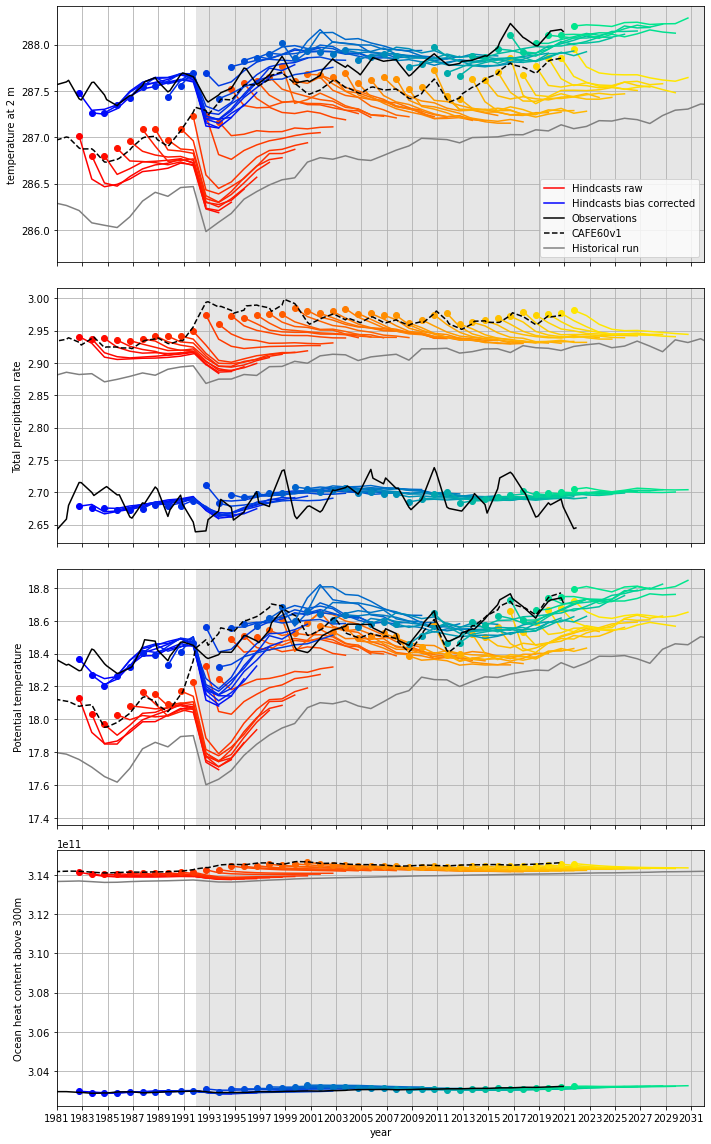

In [25]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc, cafe_hist)

That looks okay for `t_ref` and `sst` but not `precip`... What about if we do the same thing but don't limit ourselves to a consistent period at each lead

In [26]:
transition_year = 1992

period_1 = slice(
    cftime.DatetimeJulian(1963, 11, 1),
    cftime.DatetimeJulian(1991, 11, 1),
)  # 28 years

period_2 = slice(
    cftime.DatetimeJulian(1992, 11, 1),
    cftime.DatetimeJulian(2020, 11, 1),
)  # 28 years

f5_period_1 = f5_hcst.sel(init=period_1)
bias_1 = []
for l in f5_period_1.lead:
    ts = f5_period_1.sel(lead=l).swap_dims({"init": "time"})
    bias_1.append((ts - obs).mean("time").expand_dims({"lead": [l]}))
bias_1 = xr.concat(bias_1, dim="lead")

f5_period_2 = f5_hcst.sel(init=period_2)
bias_2 = []
for l in f5_period_2.lead:
    ts = f5_period_2.sel(lead=l).swap_dims({"init": "time"})
    bias_2.append((ts - obs).mean("time").expand_dims({"lead": [l]}))
bias_2 = xr.concat(bias_2, dim="lead")

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")

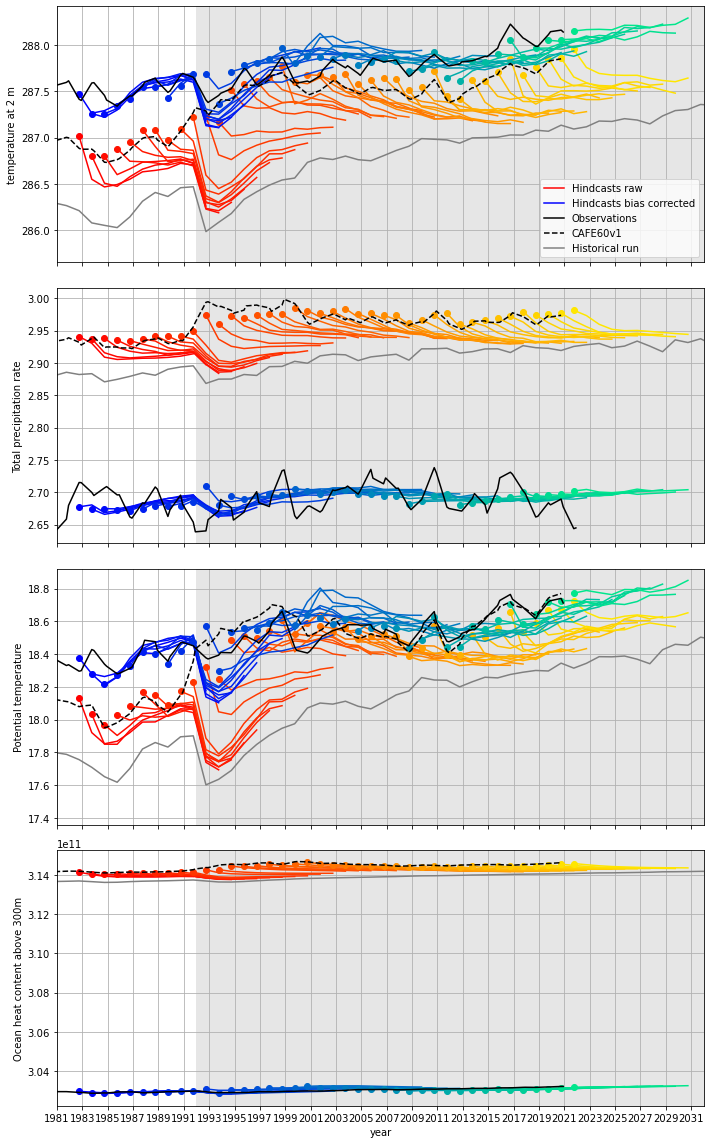

In [27]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc, cafe_hist)

Still not amazing... What about correcting for the biases on a sliding window basis, using the previous 12 years of data?

e.g. 
- for the 1981 forecast, biases are calculated over the period 1970-1981 at all leads
- for the 2020 forecast, biases are calculated over the period 2009-2020 at all leads 

This is a fair approach, but it will have to use the f5 forecasts to calculate the biases

In [28]:
n_years = 12

objs = []
for init in f6_hcst.init:
    hcst = f6_hcst.sel(init=[init.item()])

    # Calculate the bias
    clim_range = [
        hcst.get_index("init").shift(-(12 * n_years), "MS").item(),
        hcst.get_index("init").item(),
    ]

    hcst_period = (f5_hcst.time >= clim_range[0]) & (f5_hcst.time <= clim_range[1])
    obs_period = np.unique(f5_hcst.time.values[hcst_period.values])

    bias = bias_mean(
        f5_hcst.where(hcst_period),
        obs.sel(time=obs_period),
    )

    objs.append(hcst - bias)

f6_hcst_bc = xr.concat(objs, dim="init")

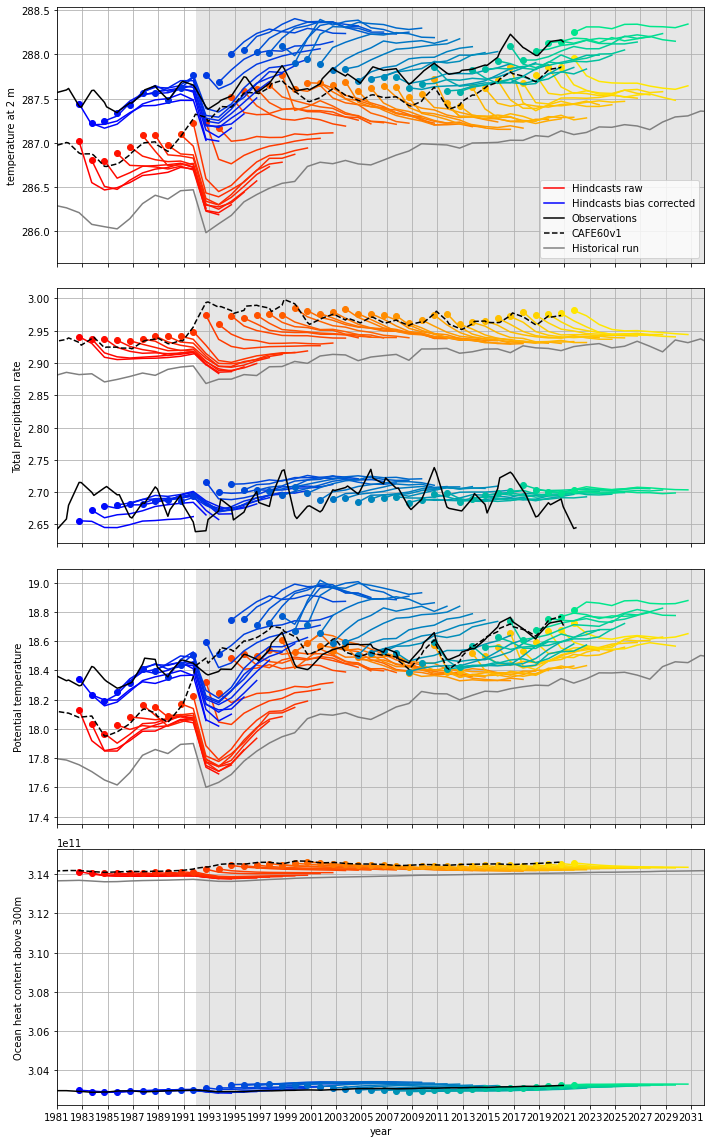

In [29]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc, cafe_hist)

What about doing this in an unfair way, selecting the period based on initial date alone?

This approach uses observations from the future to perform the bias correction at non-zero leads

In [30]:
n_years = 20

objs = []
for init in f6_hcst.init:
    hcst = f6_hcst.sel(init=[init.item()])

    init_range = slice(
        hcst.get_index("init").shift(-(12 * (n_years - 1)), "MS").item(),
        hcst.get_index("init").item(),
    )
    f5_period = f5_hcst.sel(init=init_range)
    bias = []
    for l in f5_period.lead:
        ts = f5_period.sel(lead=l).swap_dims({"init": "time"})
        bias.append((ts - obs).mean("time").expand_dims({"lead": [l]}))
    bias = xr.concat(bias, dim="lead")

    objs.append(hcst - bias)

f6_hcst_bc = xr.concat(objs, dim="init")

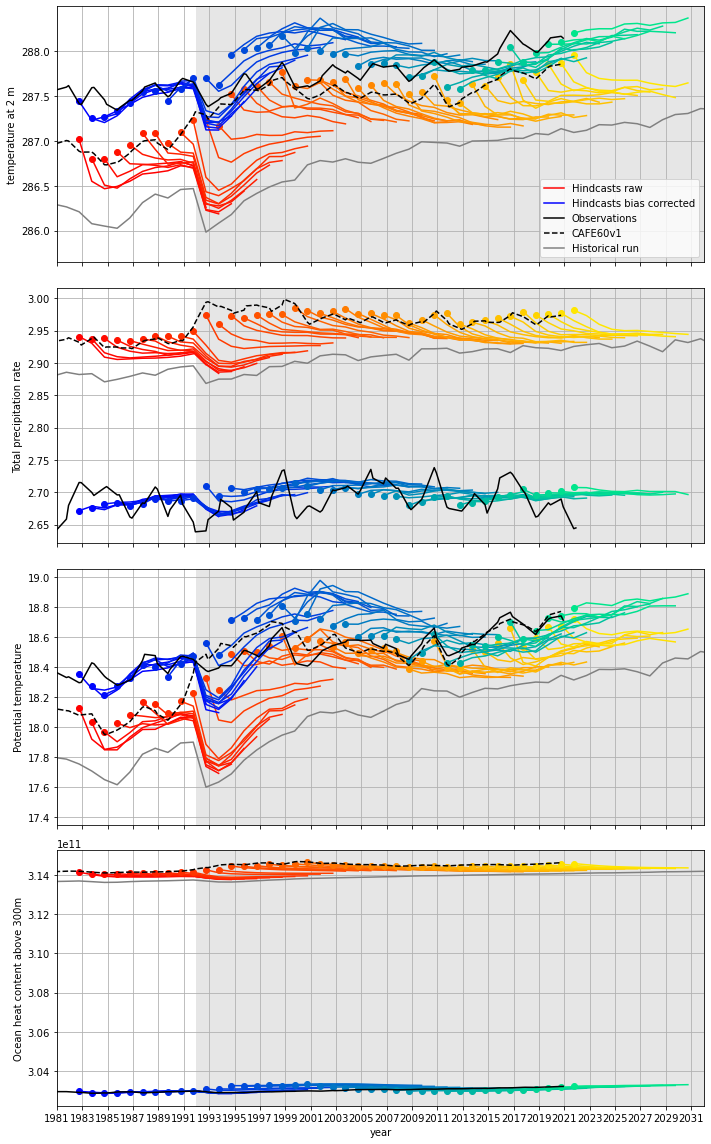

In [31]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc, cafe_hist)

What about fitting an exponential?

Of the form $D(l>0) = D(l=0) \exp(-A l)$ where $D = F - H$ is the deviation between the forecast, $F$, and the historical run, $H$; and $l$ is the lead time.

In [32]:
var = "t_ref"  # Only works on DataArrays

In [33]:
res = []
for i in f6_hcst.init:
    hcst = f6_hcst.sel(init=i).swap_dims({"lead": "time"})
    res.append((hcst - cafe_hist)[var].swap_dims({"time": "lead"}))

f6_D = xr.concat(res, dim="init")

In [34]:
from scipy.optimize import leastsq


def multiple_reg(x, y, f, const, params0, **kwargs):
    """Do same non-linear regression on multiple curves"""

    def leastsq_func(params, *args):
        x, y = args[:2]
        const = args[2:]
        yfit = []
        for i in range(len(x)):
            yfit = np.append(yfit, f(x[i], *const[i], *params))
        return y - yfit

    # turn const into 2d-array if 1d is given
    const = np.asarray(const)
    if len(const.shape) < 2:
        const = np.atleast_2d(const).T

    # ensure that y is flat and x is nested
    if hasattr(y[0], "__len__"):
        y = [item for sublist in y for item in sublist]
    if not hasattr(x[0], "__len__"):
        x = np.tile(x, (len(const), 1))
    x_ = [item for sublist in x for item in sublist]
    assert len(x_) == len(y)

    # collect all arguments in a tuple
    y = np.asarray(y)
    args = [x, y] + list(const)
    args = tuple(args)  # doesn't work if args is a list!!

    return leastsq(leastsq_func, params0, args=args, **kwargs)

In [35]:
def fit(x, D0, A, B):
    return B * D0 * np.exp(-A * x)  # B * D0 + B * D0 * np.tanh(-A * x)  #


p, _ = multiple_reg(
    f6_D.lead.values[1:], f6_D.values[:, 1:], fit, f6_D.values[:, 0], [0.1, 1]
)

In [36]:
f6_hcst_bc = []
f6_hcst_fit = []
for i in f6_D.init:
    f6_D_ts = f6_D.sel(init=i).swap_dims({"lead": "time"})
    f6_hcst_ts = f6_hcst.sel(init=i).swap_dims({"lead": "time"})
    D_fit = fit(f6_D_ts.lead, f6_D_ts.values[0], p[0], p[1])
    D_fit = xr.zeros_like(f6_hcst_ts) + D_fit
    f6_hcst_bc.append((f6_hcst_ts - D_fit).swap_dims({"time": "lead"}))
    f6_hcst_fit.append((D_fit + cafe_hist).swap_dims({"time": "lead"}))

f6_hcst_bc = xr.concat(f6_hcst_bc, dim="init")
f6_hcst_fit = xr.concat(f6_hcst_fit, dim="init")

period = [cftime.DatetimeJulian(1991, 10, 1), cftime.DatetimeJulian(2020, 10, 1)]

hcst_period = (f6_hcst_bc.time >= period[0]) & (f6_hcst_bc.time <= period[1])
obs_period = np.unique(f6_hcst_bc.time.values[hcst_period.values])

f6_clim = f6_hcst_bc.where(hcst_period).mean("init")
jra_clim = obs.sel(time=obs_period).mean("time")
bias = (f6_clim - jra_clim).mean("lead")

f6_hcst_bc = f6_hcst_bc - bias

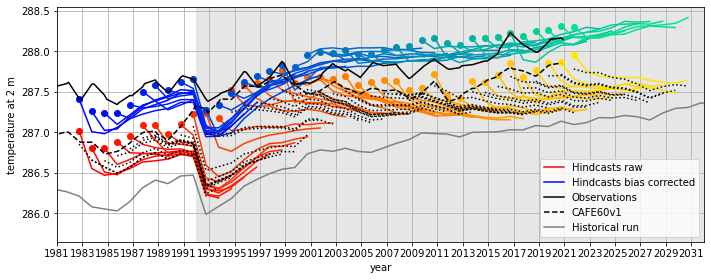

In [37]:
_ = plot_hindcasts(f6_hcst[[var]], f6_hcst_bc[[var]], cafe_hist)

for i in f6_hcst_fit.init:
    plot_fit = f6_hcst_fit[var].sel(init=i).swap_dims({"lead": "time"})
    plt.plot(plot_fit.time, plot_fit, color="k", linestyle=":")

Perhaps there is a clever way to utilize the historical run in the bias correction, but this is not it... 

What about splitting about 1992 and using the Kharin approach?

Perhaps this will make the transition a little smoother, though fitting a trend over 20 years is questionable...

In [38]:
def bias_Kharin(hcst, obs):
    def _linear_fit_in_time(da):
        p = []
        for l in da.lead:
            ts = da.sel(lead=l).swap_dims({"init": "time"})
            p.append(ts.polyfit(dim="time", deg=1).expand_dims(lead=[l]))
        return xr.concat(p, dim="lead")

    hcst_coeffs = _linear_fit_in_time(hcst)
    hcst_coeffs = hcst_coeffs.rename(
        {n: n.removesuffix("_polyfit_coefficients") for n in hcst_coeffs.data_vars}
    )
    obs_coeffs = obs.polyfit("time", deg=1)
    obs_coeffs = obs_coeffs.rename(
        {n: n.removesuffix("_polyfit_coefficients") for n in obs_coeffs.data_vars}
    )

    slope_bias_coeffs = hcst_coeffs - obs_coeffs
    slope_bias = xr.polyval(hcst["init"], slope_bias_coeffs)
    hcst_slope_corrected = hcst - slope_bias

    bias = bias_mean(hcst_slope_corrected, obs)

    return slope_bias + bias

In [39]:
transition_year = 1992

period_1 = [
    cftime.DatetimeJulian(1973, 10, 1),
    cftime.DatetimeJulian(1992, 10, 1),
]  # 20 years, using initial dates < 1992

hcst_period_1 = (f5_hcst.time >= period_1[0]) & (f5_hcst.time <= period_1[1])
obs_period_1 = np.unique(f5_hcst.time.values[hcst_period_1.values])

period_2 = [
    cftime.DatetimeJulian(2002, 10, 1),
    cftime.DatetimeJulian(2021, 10, 1),
]  # 20 years, using initial dates >= 1992

hcst_period_2 = (f5_hcst.time >= period_2[0]) & (f5_hcst.time <= period_2[1])
obs_period_2 = np.unique(f5_hcst.time.values[hcst_period_2.values])

bias_1 = bias_Kharin(f5_hcst.where(hcst_period_1), obs.sel(time=obs_period_1))

bias_2 = bias_Kharin(f5_hcst.where(hcst_period_2), obs.sel(time=obs_period_2))

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")

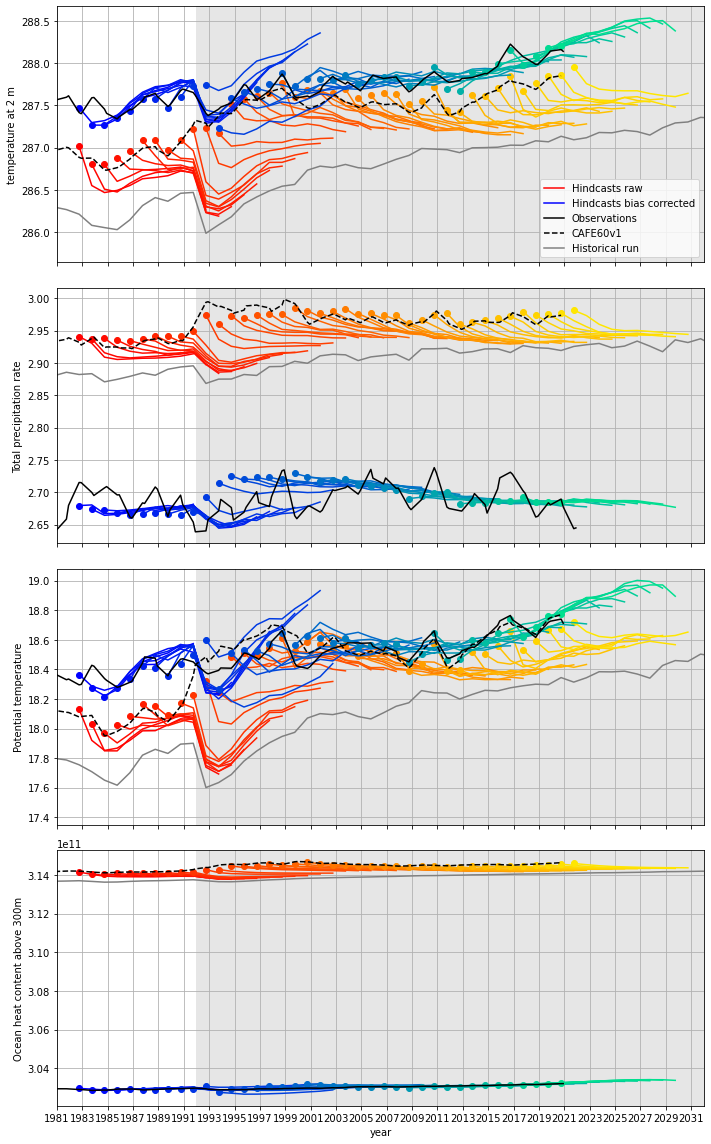

In [40]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc, cafe_hist)

This introduces a discontinuity. What about first removing the mean bias either side of 1992 first, then adjusting the slope?

In [41]:
transition_year = 1992

period_1 = [
    cftime.DatetimeJulian(1973, 10, 1),
    cftime.DatetimeJulian(1992, 10, 1),
]  # 20 years, using initial dates < 1992

hcst_period_1 = (f5_hcst.time >= period_1[0]) & (f5_hcst.time <= period_1[1])
obs_period_1 = np.unique(f5_hcst.time.values[hcst_period_1.values])

period_2 = [
    cftime.DatetimeJulian(2002, 10, 1),
    cftime.DatetimeJulian(2021, 10, 1),
]  # 20 years, using initial dates >= 1992

hcst_period_2 = (f5_hcst.time >= period_2[0]) & (f5_hcst.time <= period_2[1])
obs_period_2 = np.unique(f5_hcst.time.values[hcst_period_2.values])

bias_1 = bias_mean(
    f5_hcst.where(hcst_period_1),
    obs.sel(time=obs_period_1),
)

bias_2 = bias_mean(
    f5_hcst.where(hcst_period_2),
    obs.sel(time=obs_period_2),
)

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")


# Adjust the slope
period = [cftime.DatetimeJulian(1991, 10, 1), cftime.DatetimeJulian(2020, 10, 1)]

hcst_period = (f6_hcst.time >= period[0]) & (f6_hcst.time <= period[1])
obs_period = np.unique(f6_hcst.time.values[hcst_period.values])

bias = bias_Kharin(
    f6_hcst_bc.where(hcst_period),
    obs.sel(time=obs_period),
)

f6_hcst_bc = f6_hcst_bc - bias

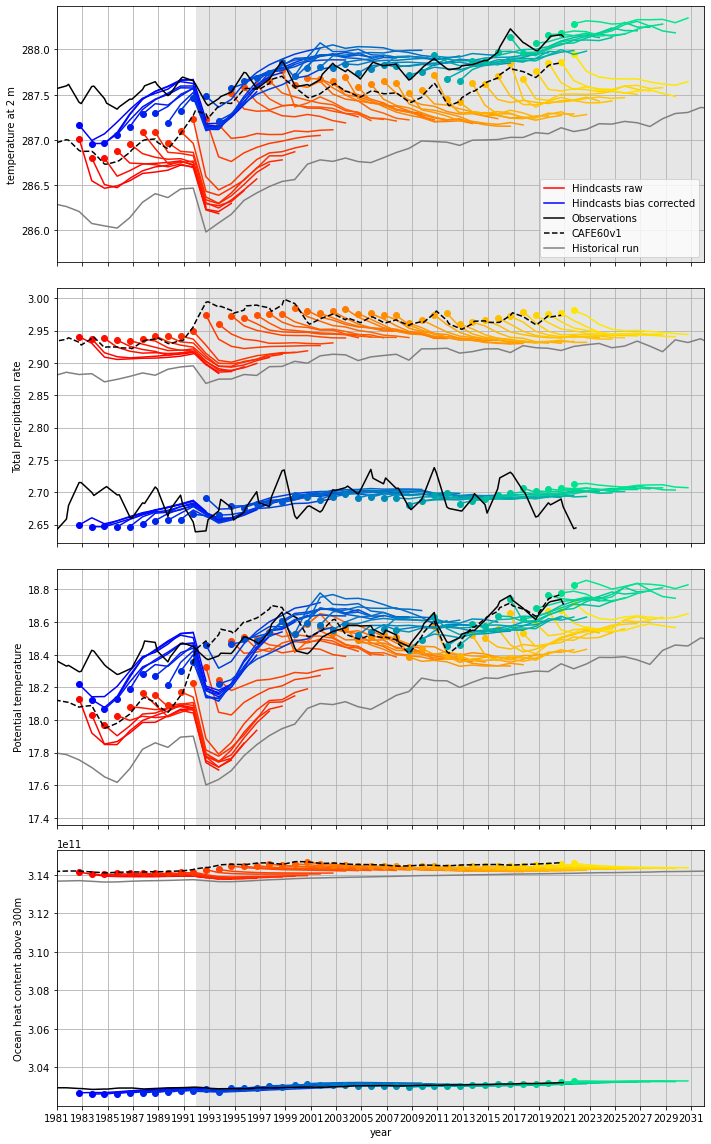

In [42]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc, cafe_hist)

The inclusion of the slope adjustment does not obviously improve things. What about just using the Kharin approach outright. This feels a little "off" because it's using a feature of the approach for the wrong reason...

In [43]:
period = [
    cftime.DatetimeJulian(1971, 10, 1),
    cftime.DatetimeJulian(2020, 10, 1),
]

hcst_period = (f5_hcst.time >= period[0]) & (f5_hcst.time <= period[1])
obs_period = np.unique(f5_hcst.time.values[hcst_period.values])

bias = bias_Kharin(
    f5_hcst.where(hcst_period),
    obs.sel(time=obs_period),
)

f6_hcst_bc = f6_hcst - bias

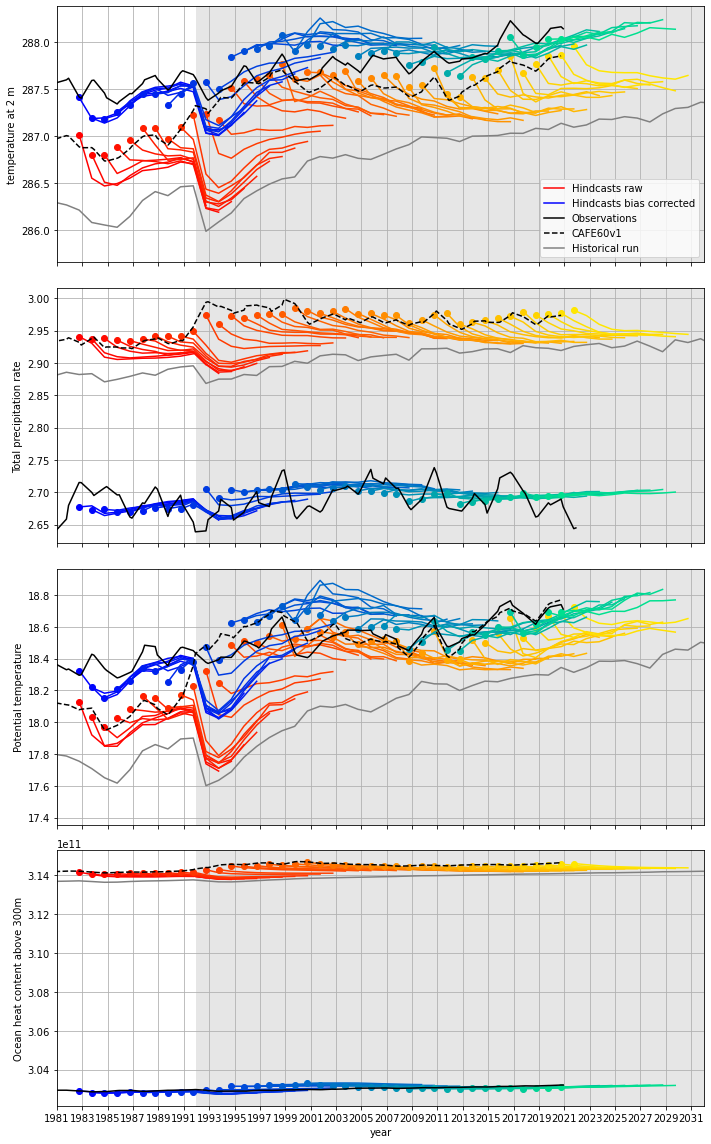

In [44]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc, cafe_hist)

Last thing to try: remove an offset calculated from CAFE-60, prior to performing the bias correction

In [45]:
# Subtract the offset
transition_year = 1992
period_1 = xr.cftime_range(
    "1964-10-01", f"{str(transition_year - 1)}-10-01", freq="12MS", calendar="julian"
)  # 28 years
period_2 = xr.cftime_range(
    f"{str(transition_year)}-10-01", "2019-10-01", freq="12MS", calendar="julian"
)  # 28 years

bias_1 = cafe_60.sel(time=period_1).mean("time") - obs.sel(time=period_1).mean("time")
bias_2 = cafe_60.sel(time=period_2).mean("time") - obs.sel(time=period_2).mean("time")

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")

# Lead dependent bias correction
period = [cftime.DatetimeJulian(1991, 10, 1), cftime.DatetimeJulian(2020, 10, 1)]

hcst_period = (f6_hcst_bc.time >= period[0]) & (f6_hcst_bc.time <= period[1])
obs_period = np.unique(f6_hcst.time.values[hcst_period.values])

bias = bias_mean(
    f6_hcst_bc.where(hcst_period),
    obs.sel(time=obs_period),
)

f6_hcst_bc = f6_hcst_bc - bias

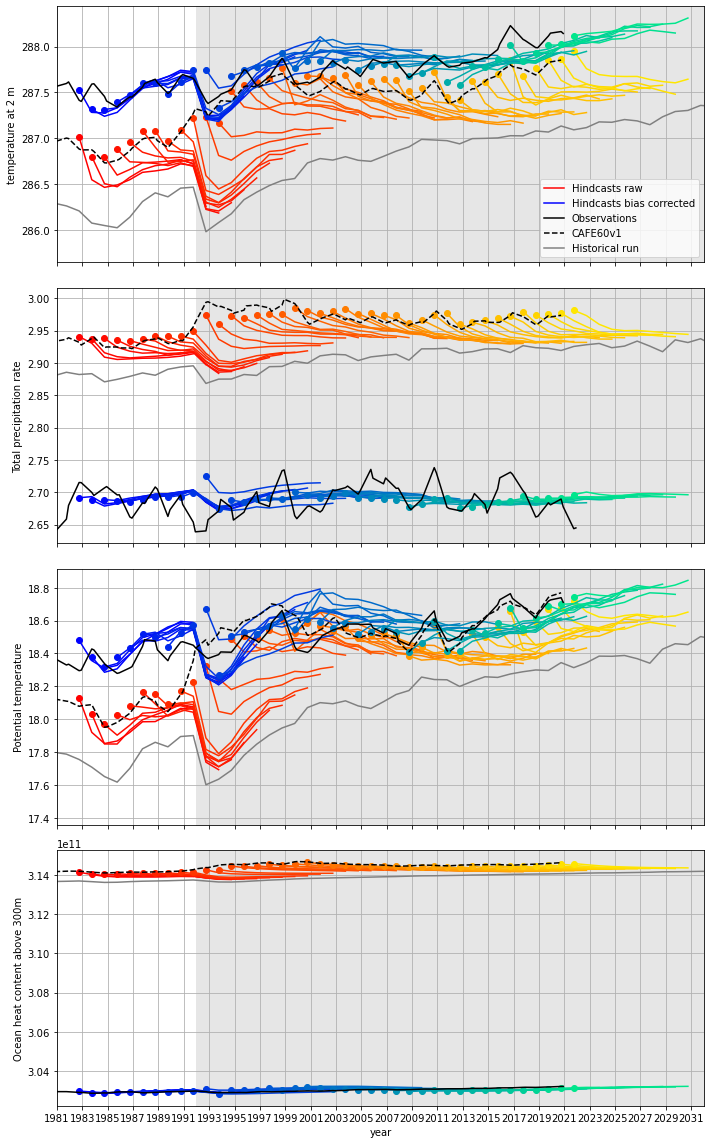

In [46]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc, cafe_hist)

Could we just do all verification relative to CAFE60v1? How would we interpret this? Can we justify that this is a sensible thing to do?